# Lightning Workflow for Contrails
## Implementing a U-Net architecture model and using the spectral index approach during preproccesing

In [1]:
!pip install lightning -q

In [2]:
# lightning library
import lightning as L
from lightning import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.callbacks.progress import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping


# pytorch libraries
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchmetrics.classification import Dice
from torchmetrics import Precision, Recall, Accuracy

# other
import os
import subprocess
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.core.display import display
from PIL import Image

# set base directory
BASE_DIR = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"

# set batch size
BATCH_SIZE = 16 if torch.cuda.is_available() else 8
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Short EDA

In [3]:
# List all examples from the train / val / test directories
train_list = os.listdir(BASE_DIR + '/train/')
val_list = os.listdir(BASE_DIR + '/validation/')
test_list = os.listdir(BASE_DIR + '/test/')

print(f"number of traning examples: {len(train_list)}")
print(f"number of validation examples: {len(val_list)}")
print(f"number of test examples: {len(test_list)}")

number of traning examples: 20529
number of validation examples: 1856
number of test examples: 2


In [4]:
# see files for an arbitrary training example
band_list = os.listdir(BASE_DIR + '/train/' + train_list[0])
print(band_list)
print(np.load(BASE_DIR + '/train/' + train_list[0] + '/band_10.npy').shape)

['band_10.npy', 'band_14.npy', 'human_individual_masks.npy', 'band_15.npy', 'band_16.npy', 'band_08.npy', 'band_09.npy', 'band_13.npy', 'band_11.npy', 'human_pixel_masks.npy', 'band_12.npy']
(256, 256, 8)


### Preparing to standardize the data

"Each input channel is standardized by subtracting the global mean and dividing by the global variance of the channel before feeding it into the network" (Joe et al., 2023).

In [5]:
# create empty dicts to store band-specific global mean and std
mean_list = {}
std_list = {}

# calculate global means and stds to normalize the data before training
for n_channel, channel in enumerate(band_list):
    channel_data = []
    
    for band in band_list:
        band_data = []
    
        for train_example in train_list[:300]:
            example_data = np.load(BASE_DIR + '/train/' + train_list[n_channel] + '/' + band).flatten()
        
        band_data.append(example_data)
    
    channel_data.append(np.concatenate(band_data))  
    mean_list[channel] = np.mean(channel_data)
    std_list[channel] = np.std(channel_data)

# Use spectral index approach suggested by preprocessing group
They found the spectral index calculated from bands 13 and 14 to be most promising.

In [6]:
limits_spectralIndex = {
        (13, 14): (-1.8499428, 0.17252406),
        }

In [7]:
def load_band(band_number, record_id, **kwargs):
    # access base dir
    BASE_DIR = kwargs["BASE_DIR"]
    
    # load band
    with open(os.path.join(BASE_DIR, record_id, f'band_{band_number:02}.npy'), 'rb') as f:
        band_i = np.load(f)
        
    return band_i

def calc_spectral_index(A, B, lam):
    '''A, B: dicts with band number and band field
       lam: wavelengths'''
    SI = np.log(A['field']/B['field'])/ np.log(lam[A['number']]/lam[B['number']])
    return SI

def base_spectral_index(band_numberA, band_numberB, record_id, limit_frame = True, **kwargs):
    # get wavelengths
    lam   = kwargs["lambda"]
    
    # individual bands
    bandA = load_band(band_numberA,record_id=record_id, **kwargs)
    bandB = load_band(band_numberB,record_id=record_id, **kwargs)

    # calculate spectral index
    spectral_index = calc_spectral_index({'number': band_numberA, 'field': bandA}, {'number': band_numberB, 'field': bandB}, lam) #np.log(bandA/bandB)/ np.log(lam[band_numberA]/lam[band_numberB])
    
    if limit_frame:
        # get just one frame of interest
        spectral_index = spectral_index[..., kwargs["N_TIMES_BEFORE"]]
        
    return spectral_index

def normalize_range(spectral_map, band_numberA, band_numberB, **kwargs):
    """Maps spectral_map to the range [0, 1]."""
    # get bounds
    s_min, s_max = kwargs["limits_spectralIndex"][(min(band_numberA, band_numberB),max(band_numberA, band_numberB))]
    
    # normalize
    return (spectral_map - s_min) / (s_max - s_min)


def load_spectral_index(record_id, band_numberA = 13, band_numberB= 14, limit_frame = False, **kwargs):
    # get spectral index map
    s_map = base_spectral_index(band_numberA, band_numberB, record_id = record_id, limit_frame = limit_frame, **kwargs)
    
    # normalize it
    s_map = normalize_range(s_map, band_numberA, band_numberB, **kwargs)
    
    # clip it
    s_map = np.clip(s_map, 0, 1)
    
    return s_map

In [8]:
class ContrailsDataset_SI(Dataset):
    def __init__(self, base_dir, data_type='train', transform=None):
        assert data_type in ['train', 'validation', 'test'], \
            "'data_type' should be one of 'train', 'validation', or 'test'"

        self.base_dir = base_dir
        self.data_type = data_type
        self.transform = transform
        self.record = os.listdir(self.base_dir +'/'+ self.data_type)
        self.baseSettings_SpectralIndex = {
            "BASE_DIR": self.base_dir +'/'+ self.data_type,
            "example_record_id": '1704010292581573769',
            "lambda": np.array([0.,0.47,0.64,0.86,1.37,1.6,2.2,3.9,6.2,6.9,7.3,8.4,9.6,10.3,11.2,12.3,13.3]),
            "N_TIMES_BEFORE": 4,
            "limits_spectralIndex": limits_spectralIndex
        }


    def __len__(self):
        return len(self.record)

    def __getitem__(self, idx):
        record_id = self.record[idx]
        record_dir = os.path.join(self.base_dir, self.data_type, record_id)
        
        sample = load_spectral_index(
                            record_id = record_id, 
                            band_numberA = 13, 
                            band_numberB = 14, 
                            limit_frame = True, 
                            **self.baseSettings_SpectralIndex)
        
        
        if self.transform:
            sample = self.transform(sample)
        
        #sample = sample.permute(1,0,2,3)

        
        targets = np.load(os.path.join(record_dir, "human_pixel_masks.npy"))
        targets = targets[..., -1]
        targets = torch.tensor(targets).to(torch.long)
        #targets.permute(3,0,1,2)
        
        return sample, targets
    
#train_data = ContrailsDataset_SI(BASE_DIR, data_type='train')
#example, targets = train_data[0]
#print(example.shape)

In [9]:
# calculate mean and std for spectral index

bandA_filename = 'band_13.npy'
bandB_filename = 'band_14.npy'
lam = np.array([0.,0.47,0.64,0.86,1.37,1.6,2.2,3.9,6.2,6.9,7.3,8.4,9.6,10.3,11.2,12.3,13.3])
    
mean_SI = calc_spectral_index({'number': 13, 'field': mean_list[bandA_filename]},
                              {'number': 14, 'field': mean_list[bandB_filename]},
                              lam)
std_SI = calc_spectral_index({'number': 13, 'field': std_list[bandA_filename]},
                             {'number': 14, 'field': std_list[bandB_filename]},
                             lam)

In [10]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_SI, std_SI)])  # normalize with the mean and std calculated above

In [11]:
# Create your datasets
train_dataset = ContrailsDataset_SI(
    base_dir = BASE_DIR,
    data_type = 'train',
    transform = transform,
)

val_dataset = ContrailsDataset_SI(
    base_dir = BASE_DIR,
    data_type = 'validation',
    transform = transform,
)

# Create your dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [12]:
# load one batch of images and labels
dataiter = iter(train_dataloader)
images, targets = next(dataiter)

# check shapes of the batch
print(images.shape)
print(targets.shape)

torch.Size([16, 1, 256, 256])
torch.Size([16, 256, 256])


## Lightning Data Module

In [13]:
class ContrailsDataModule_SI(L.LightningDataModule):
    def __init__(
        self,
        base_dir: str = BASE_DIR,
        batch_size: int = BATCH_SIZE,
        timestep: int = 4,
    ):
    
        super().__init__()
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.timestep = timestep
        
        # Transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean_SI, std_SI)])

                
    def prepare_data(self):
        pass

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:

            self.train_dataset = ContrailsDataset_SI(
                base_dir = self.base_dir,
                data_type = 'train', 
                transform=self.transform,
                )
            
            self.val_dataset = ContrailsDataset_SI(
                base_dir = self.base_dir,
                data_type = 'validation', 
                transform=self.transform,
                )

        
        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            
                self.test_dataset = ContrailsDataset(
                base_dir = self.base_dir,
                data_type = 'test', 
                transform=self.transform,
                )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size, 
                          shuffle=False,
                         )
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                         shuffle=False)

## Implement the U-Net Model from https://paperswithcode.com/method/u-net

In [14]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [15]:
class U_Net(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, lr=0.001):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.learning_rate = lr
        
        # counter and accumulator for progress
        self.counter = 0
        self.progress = []
        
        # loss
        self.loss_function = nn.CrossEntropyLoss()
        
        # optimizer
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate)

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    
    def train(self, input, target):
        pred = self(input)
        loss = self.loss(pred, target)
        
        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass
        
        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

## Creating the Lightning Module for training

In [16]:
class Contrails_U_Net(L.LightningModule):
    def __init__(self, learning_rate=1e-5, n_channels = 1, n_classes = 2):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.model = UNet2(self.n_channels, self.n_classes)
        self.CEL = nn.CrossEntropyLoss(weight = torch.Tensor([0.57, 4.17]))
        self.learning_rate = learning_rate
        
        self.precision = Precision(task="binary", average='macro', num_classes=2) # binary classification 
        self.recall = Recall(task="binary", average='macro', num_classes=2)  
        self.accuracy = Accuracy(task="binary", average='macro', num_classes=2)        
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.CEL(logits, y)
        
        # Compute metrics
        train_precision = self.precision(logits.softmax(dim=1)[:, 1, ...], y)
        train_recall = self.recall(logits.softmax(dim=1)[:, 1, ...], y)
        train_accuracy = self.accuracy(logits.softmax(dim=1)[:, 1, ...], y)

        # Logging metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_precision', train_precision, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_recall', train_recall, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_accuracy', train_accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.CEL(logits, y)

        # Compute metrics
        val_precision = self.precision(logits.softmax(dim=1)[:, 1, ...], y)
        val_recall = self.recall(logits.softmax(dim=1)[:, 1, ...], y)
        val_accuracy = self.accuracy(logits.softmax(dim=1)[:, 1, ...], y)
        #val_dice = self.dice(logits.softmax(dim=1)[:, 1, ...], y)

        # Logging metrics
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_precision', val_precision, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_recall', val_recall, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_accuracy', val_accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        #self.log('val_dice', val_dice, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.CEL(logits, y)

        # Compute metrics
        test_precision = self.precision(logits.softmax(dim=1)[:, 1, ...], y)
        test_recall = self.recall(logits.softmax(dim=1)[:, 1, ...], y)
        test_accuracy = self.accuracy(logits.softmax(dim=1)[:, 1, ...], y)
        #test_dice = self.dice(logits.softmax(dim=1)[:, 1, ...], y) # Compute Dice for test set


        # Logging metrics
        self.log('test_loss', loss, prog_bar=True, logger=True)
        self.log('test_precision', test_precision, prog_bar=True, logger=True)
        self.log('test_recall', test_recall, prog_bar=True, logger=True)
        self.log('test_accuracy', test_accuracy, prog_bar=True, logger=True)
        #self.log('test_dice', test_dice, prog_bar=True, logger=True)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
        

### Create early-stopping and checkpoint callback function 

In [17]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience=3,
   verbose=False,
   mode='min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='model/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min')

## Training..!

In [21]:
model = Contrails_U_Net(learning_rate=5e-4)
dm = ContrailsDataModule_SI(BASE_DIR, batch_size=16)

# create the csv logger for results
# Instantiate CSV logger
csv_logger = CSVLogger('logs/', name='csv_log')


trainer = Trainer(
    accelerator="auto",
    devices = "auto",
    max_epochs=5,
    callbacks=[TQDMProgressBar(refresh_rate=20), early_stop_callback], # optional: early_stop_callback, checkpoint_callback
    logger=csv_logger,
    log_every_n_steps =50,
)
trainer.fit(model, dm)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO: Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

INFO: LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UNet2            | 17.3 M
1 | CEL       | CrossEntropyLoss | 0     
2 | precision | BinaryPrecision  | 0     
3 | recall    | BinaryRecall     | 0     
4 | accuracy  | BinaryAccuracy   | 0     

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('val_precision', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('val_recall', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/lightning/pyto

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('train_precision', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('train_recall', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/lightnin

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.


## Plot training progress

In [26]:
# Read data from CSV file
log_data = pd.read_csv('logs/csv_log/version_1/metrics.csv')
log_data.columns

Index(['train_loss_step', 'epoch', 'step', 'val_loss_step', 'val_loss_epoch',
       'val_precision', 'val_recall', 'val_accuracy', 'train_loss_epoch',
       'train_precision', 'train_recall', 'train_accuracy'],
      dtype='object')

In [40]:
# retain values that are not nan 
def notna_values(data, var_name):
    return data[data[var_name].notna()][var_name]

In [42]:
notna_values(log_data, 'val_loss_epoch')

70     0.065353
143    0.073466
216    0.084457
289    0.058579
362    0.047908
Name: val_loss_epoch, dtype: float64

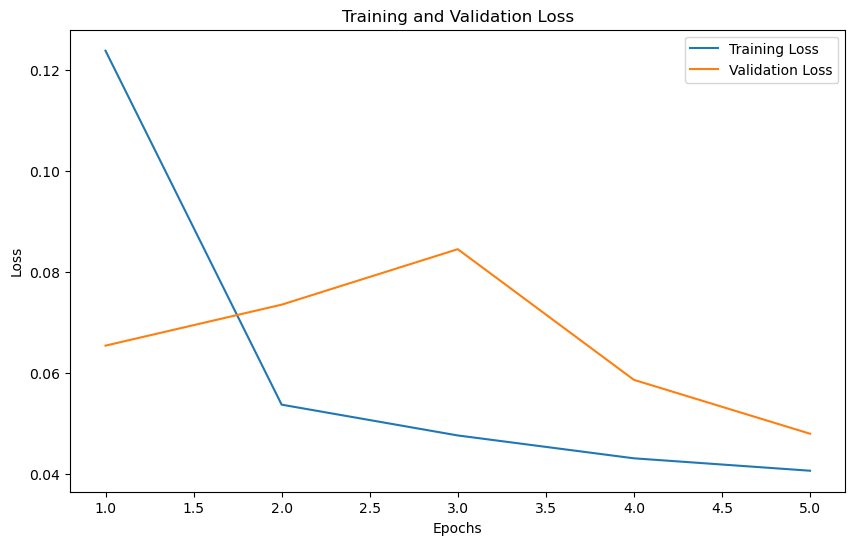

<Figure size 640x480 with 0 Axes>

In [47]:
#Plot training loss
epochs = np.arange(1,6)
plt.figure(figsize=(10,6))
plt.plot(epochs, notna_values(log_data, 'train_loss_epoch'), label='Training Loss')
plt.plot(epochs, notna_values(log_data, 'val_loss_epoch'), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()

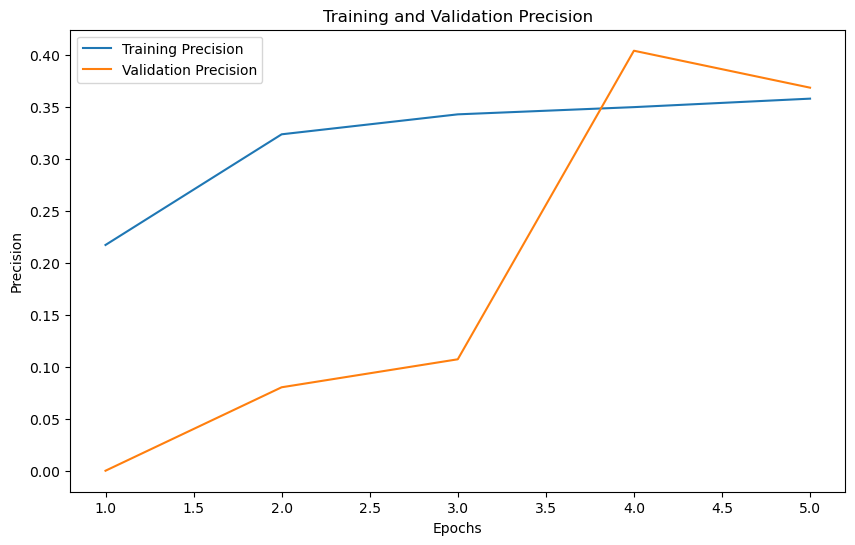

In [50]:
# Plot training precision
plt.figure(figsize=(10,6))
plt.plot(epochs, notna_values(log_data,'train_precision'), label='Training Precision')
plt.plot(epochs, notna_values(log_data,'val_precision'), label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

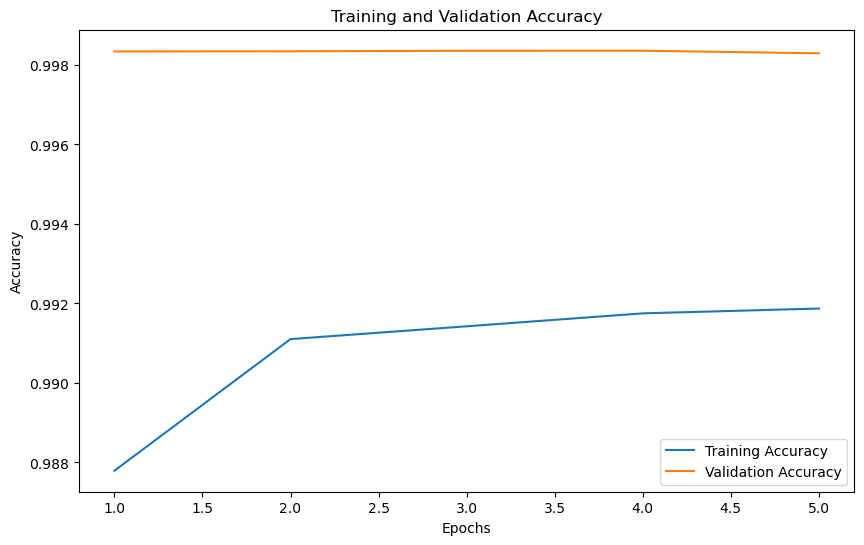

In [52]:
# Plot training accuracy
plt.figure(figsize=(10,6))
plt.plot(epochs, notna_values(log_data,'train_accuracy'), label='Training Accuracy')
plt.plot(epochs, notna_values(log_data,'val_accuracy'), label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()